<a href="https://colab.research.google.com/github/w2j1y12/pdm17/blob/main/py-tensorflow/pdm17_final/cifar10_resnet50_TL_Model2_Functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Transfer Learning
In this notebook, we will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.

> https://www.kaggle.com/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner


# Transfer Learning(TL)
- 하나의 문제를 해결하고 다른 관련 문제에 적요하면서 얻은 지식을 저장하는데 초점을 맞춘 기계 학습
- 새로운 작업을 학습하기 전에 학습한 작업의 정보를 재사용하거나 이전하는 것은 강화 학습 에이전트의 샘플 효율성을 향상시킬 수 있음

# TL 결과 요약
- loss: 0.0013 
- accuracy: 0.9997 
- val_loss: 0.1957 
- val_accuracy: 0.9558

## Imports

In [ ]:
import os, re, time, json
import numpy as np
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


## Parameters

- Define the batch size
- Define the class (category) names

In [ ]:
# BATCH_SIZE = 100 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help us to create some visualizations. 

In [ ]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(classes[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

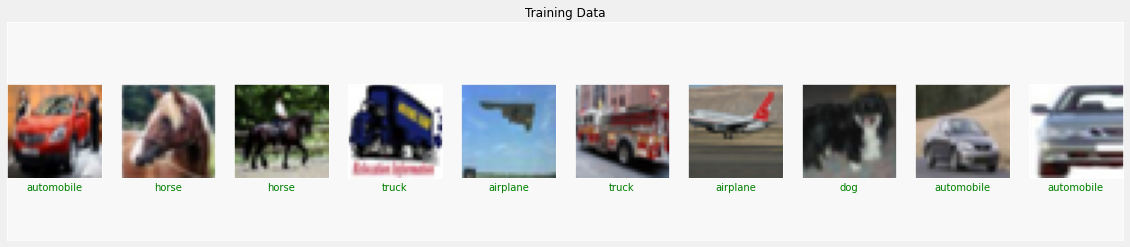

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

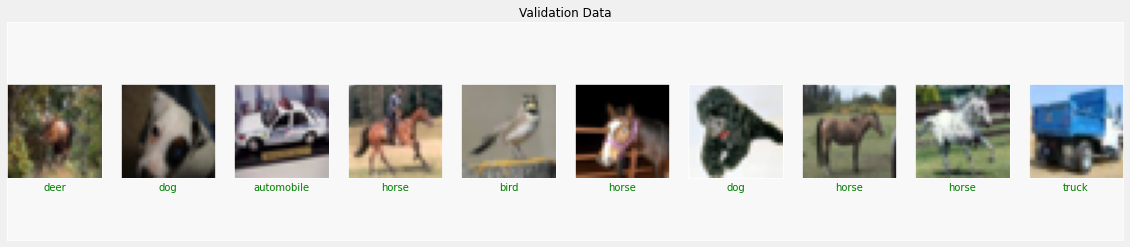

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Validation Data" )

### Preprocess Dataset
Here, we'll perform normalization on images in training and validation set. 
- We'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
We will be performing transfer learning on **ResNet50** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./cifar10_resnet50_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=3)

## Train the model

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64  # 32, 100
history = model.fit(train_X, training_labels, 
                    epochs=EPOCHS, 
                    validation_data = (valid_X, validation_labels), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8664

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


782/782 [==============================] - 1104s 1s/step - loss: 0.4081 - accuracy: 0.8664 - val_loss: 0.2027 - val_accuracy: 0.9293
Epoch 2/20
782/782 [==============================] - 1084s 1s/step - loss: 0.1007 - accuracy: 0.9668 - val_loss: 0.2065 - val_accuracy: 0.9335
Epoch 3/20
782/782 [==============================] - 1084s 1s/step - loss: 0.0351 - accuracy: 0.9899 - val_loss: 0.1767 - val_accuracy: 0.9463
Epoch 4/20
782/782 [==============================] - 1103s 1s/step - loss: 0.0136 - accuracy: 0.9969 - val_loss: 0.1751 - val_accuracy: 0.9496
Epoch 5/20
782/782 [==============================] - 1084s 1s/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.1810 - val_accuracy: 0.9509
Epoch 6/20
782/782 [==============================] - 1084s 1s/step - loss: 0.0045 - accuracy: 0.9995 - val_loss: 0.1737 - val_accuracy: 0.9538
Epoch 7/20
782/782 [==============================] - 1083s 1s/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.1907 - val_accuracy: 0.9515
Epo

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=BATCH_SIZE)

157/157 [==============================] - 59s 376ms/step - loss: 0.1957 - accuracy: 0.9558


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

In [ ]:
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

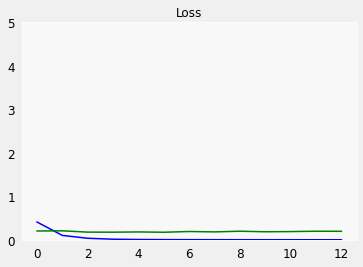

In [ ]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

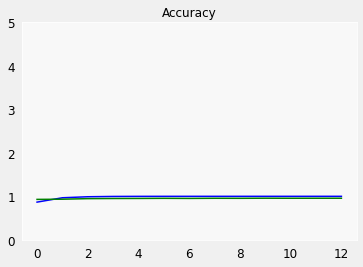

In [ ]:
plot_metrics("accuracy", "Accuracy")

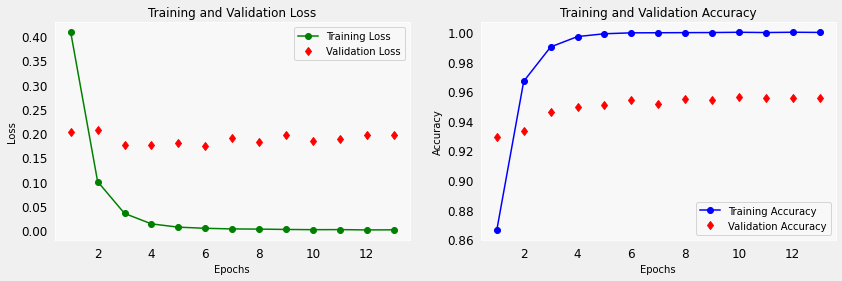

In [ ]:
# More graphs of loss and accuracy
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'go-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'rd', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy', c='blue')
plt.plot(epochs, val_acc, 'rd', label='Validation Accuracy', c='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Visualize predictions
We can take a look at the predictions on the validation set.

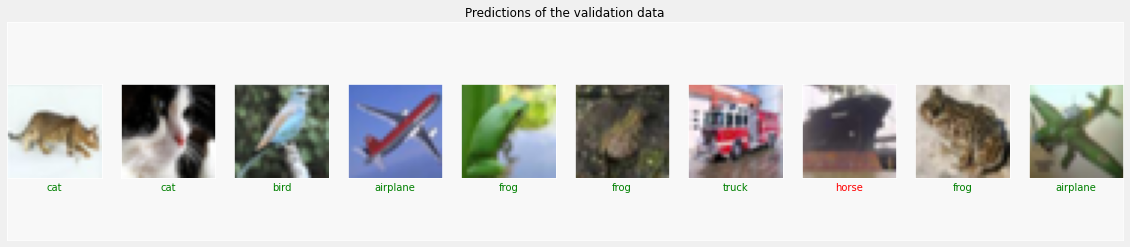

In [ ]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Predictions of the validation data")